In [1]:
#Import requirments
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import mean_squared_error


#import custom transformer class
from custom_transformer import CombinedAttributesAdder

In [2]:
#define contants
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
#Get housing data from internet, make dirs, extract datasets
def fetch_housing_data(housing_url = HOUSING_URL,housing_path = HOUSING_PATH):
    os.makedirs(housing_path,exist_ok = True)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    

#load dataset into variable
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#Niave method to split the dataset into testing and training
def split_train_test(data, ratio):
    #shuffled list of indices for each object in dataset
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    #Calculate how many objects should be in the test set
    test_size = int(len(data)*ratio)
    #grab every element with index less than test size
    test_indices = shuffled_indices[:test_size]
    #grab every element with index greater than test size
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

#Kfold cross validation method using root mean squared error that can automatically handle data 
#sets that are log scaled w/o giving artificially low error relative to the non scaled model.
def Kfold_RMSE(X,y,log_data,n,model):
    
    regressor = model()
    
    X = np.array(X)
    y = np.array(y)

    kf = KFold(n_splits=n)
    kf.get_n_splits(X)
    
    rmse_list = []

    for train_index, test_index in kf.split(X):
        train_index = train_index 
        test_index =test_index 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        regressor.fit(X_train,y_train)
        predictions = regressor.predict(X_test)
        if log_data == True:
            error = mean_squared_error(np.exp(y_test), np.exp(predictions))
        else:
            error = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(error)
        rmse_list.append(rmse)
    
    err = np.array(rmse_list)
    mean_err = np.sum(err)/len(err)
    std = err.std()
    print(f"mean error is: {mean_err:.2f} with a standard deviation of {std:.2f}")
    return err, mean_err, std
    

In [4]:
#gather and load california housing dataset
fetch_housing_data(housing_url = HOUSING_URL,housing_path = HOUSING_PATH)
housing = load_housing_data(housing_path = HOUSING_PATH)

# DATA EXPLORATION

In [5]:
#print summary of housing dataset
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
#print attribute information
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
#count missing values in each column
print(housing.isna().sum())
print(f"Only {(207/20640): .2%} of toatal_bedrooms is missing")

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64
Only  1.00% of toatal_bedrooms is missing


In [8]:
#Get descriptive stats
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


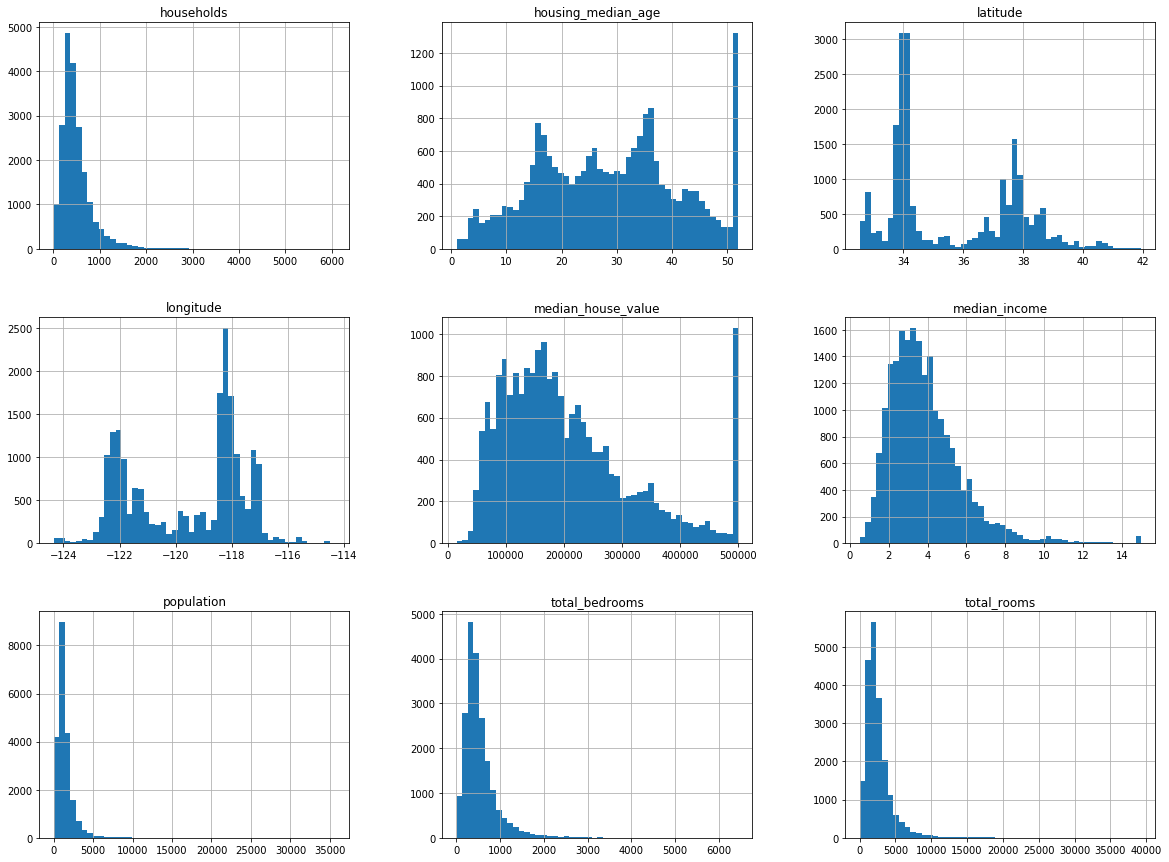

In [9]:
#Hist the numerical attrs
housing.hist(bins = 50, figsize = (20,15));

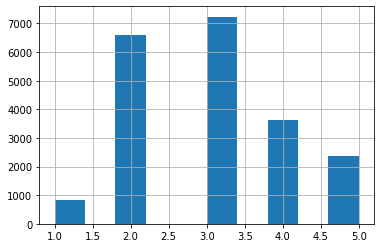

In [10]:
#Split into testing and training using stratiefied sampling on the income attribute

#create a discrete version of median_income for the strata
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins = [0.0,1.5,3.0,4.5,6,np.inf],
                              labels = [1,2,3,4,5])
#plot new attr
housing["income_cat"].hist();

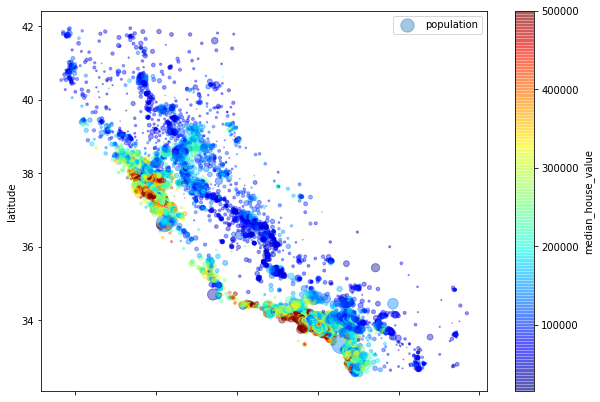

In [11]:
#plot geospatial data
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"]/100, label = "population", figsize = (10,7),
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend();

In [12]:
#Explore how the attributes are correlated to the target attribute
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

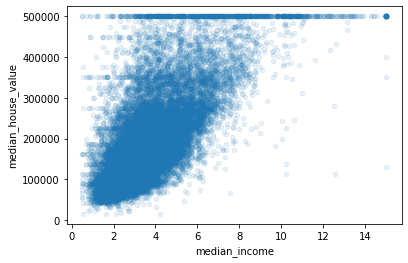

In [13]:
#plot house prices vs median income
housing.plot(kind = "scatter", x= "median_income", y = "median_house_value", alpha  = 0.1);

In [14]:
#Explore diff attr combinations 
housing["beds_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
#Explore how the attributes are correlated to the target attribute
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
beds_per_room        -0.255880
Name: median_house_value, dtype: float64

# PREPROCESSING

In [15]:
#Split The Data Into Test And Train using stratified sampling


#create split object
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

#take a representative sample of the pop for both test and train.
for train_index, test_index in split.split(housing,housing["income_cat"]):
    train_set = housing.iloc[train_index]
    test_set = housing.iloc[test_index]
    
#remove the income catagory attribute from test and training sets
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

C:\Users\Monty\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
#first split the target off from the other attributes in training set
housing_training = train_set.drop("median_house_value", axis = 1)
labels_train = train_set["median_house_value"].copy()


#first split the target off from the other attributes in test set
housing_test = test_set.drop("median_house_value", axis = 1)
labels_test = test_set["median_house_value"].copy()

In [17]:
#Impute the missing data in beadrooms.


#initialize imputer object
imputer = SimpleImputer(strategy = "median")
#drop catagorical attrs from train/test
housing_num = housing_training.drop("ocean_proximity", axis = 1)
housing_num_test = housing_test.drop("ocean_proximity", axis = 1)
#fit the imputer on the train set and transorm train/test
imputer.fit(housing_num)
X_train = imputer.transform(housing_num)
X_test = imputer.transform(housing_num_test)
#convert training set back to dataframe
housing_tr = pd.DataFrame(X_train,columns = housing_num.columns,
                         index = housing_num.index)

#convert test set back to dataframe
housing_tr_test = pd.DataFrame(X_test,columns = housing_num_test.columns,
                         index = housing_num_test.index)

In [18]:
#train/test now contain all of the numerical attrs with no missing data
#Housing_tr excludes Ocean Proximity, which is a string catagorical value
#Best to convert this to a numerical type for the algorithms




#isolate catagorical attributes
housing_cat = housing_training[["ocean_proximity"]]
housing_cat_test = test_set[["ocean_proximity"]]


#apply one hot encoding to the catagorical attributes
housing_cat_1hot = pd.get_dummies(housing_cat, prefix=["ocean_proximity"], columns = ["ocean_proximity"], drop_first=True)
housing_cat_1hot_test = pd.get_dummies(housing_cat_test, prefix=["ocean_proximity"], columns = ["ocean_proximity"], drop_first=True)

#add the encoded attributes back to the training set
attrs1 = [housing_tr, housing_cat_1hot]
train = pd.concat(attrs1, axis = 1)

#add the encoded cat attributes and target back to the testing set
attrs2 = [housing_tr_test, housing_cat_1hot_test]
test = pd.concat(attrs2, axis = 1)

In [19]:
#Use custom class to add some engineered attributes
#These are rooms per household, pop per household, and bedrooms per household




#initialize our attribute adder.
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)


#transform training set.
train_extra_attribs = attr_adder.transform(train.values,test)

#convert training set back to dataframe
train = pd.DataFrame(
    train_extra_attribs,
    columns=list(train.columns)+["rooms_per_household", "population_per_household","bedrooms_per_room"],
    index=train.index)


#transform test set
test_extra_attribs = attr_adder.transform(test.values,test)

#convert test set back to dataframe
test = pd.DataFrame(
    test_extra_attribs,
    columns=list(test.columns)+["rooms_per_household", "population_per_household","bedrooms_per_room"],
    index=test.index)

In [20]:
#remove outliers from the train set and its labels

#check for which points the z score is above a threshhold and remove them
z = np.abs(stats.zscore(train))
train = train[(z < 5).all(axis=1)]
labels_train = labels_train[(z < 5).all(axis=1)]
print(len((z < 5).all(axis=1)))

16512


In [21]:
#transform std_train/std_test and train/test labels to reduce skewness



#Remove the one-hot-encoded attrs from the scaling
drop_cols = ["ocean_proximity_INLAND","ocean_proximity_ISLAND","ocean_proximity_NEAR BAY","ocean_proximity_NEAR OCEAN","longitude","latitude","housing_median_age"]

pre_train = train.drop(drop_cols, axis = 1)
pre_test = test.drop(drop_cols, axis = 1)


#decrease skewness of test/train set with cube root transform
pre_train = np.log(pre_train)
pre_test = np.log(pre_test)

#decrease skewness of target sets with cube root transform
labels_train_trans = np.log(labels_train)
labels_test_trans = np.log(labels_test)

#return datasets back to dataframe
pre_train = pd.DataFrame(pre_train,columns = pre_train.columns,
                         index = pre_train.index)

pre_test = pd.DataFrame(pre_test,columns = pre_test.columns,
                         index = pre_test.index)


#add the encoded attributes back to the training set
attrs1 = [pre_train, train[drop_cols]]
pre_train = pd.concat(attrs1, axis = 1)

#add the encoded cat attributes and target back to the testing set
attrs2 = [pre_test, test[drop_cols]]
pre_test = pd.concat(attrs2, axis = 1)

In [22]:
#scale the attributes of test/train using standardization


scaler = StandardScaler()

#Remove the one-hot-encoded attrs from the scaling
cat_cols = ["ocean_proximity_INLAND","ocean_proximity_ISLAND","ocean_proximity_NEAR BAY","ocean_proximity_NEAR OCEAN"]
scaled_train = pre_train.drop(cat_cols, axis = 1)
scaled_test = pre_test.drop(cat_cols, axis = 1)

#fit scaler and transform datasets
scaler.fit(scaled_train)
X_train = scaler.transform(scaled_train)
X_test = scaler.transform(scaled_test)


#return datasets back to dataframe
X_train = pd.DataFrame(X_train,columns = scaled_train.columns,
                         index = scaled_train.index)

X_test = pd.DataFrame(X_test,columns = scaled_test.columns,
                         index = scaled_test.index)


#add the encoded attributes back to the training set
attrs1 = [X_train, train[cat_cols]]
std_train = pd.concat(attrs1, axis = 1)

#add the encoded cat attributes and target back to the testing set
attrs2 = [X_test, test[cat_cols]]
std_test = pd.concat(attrs2, axis = 1)

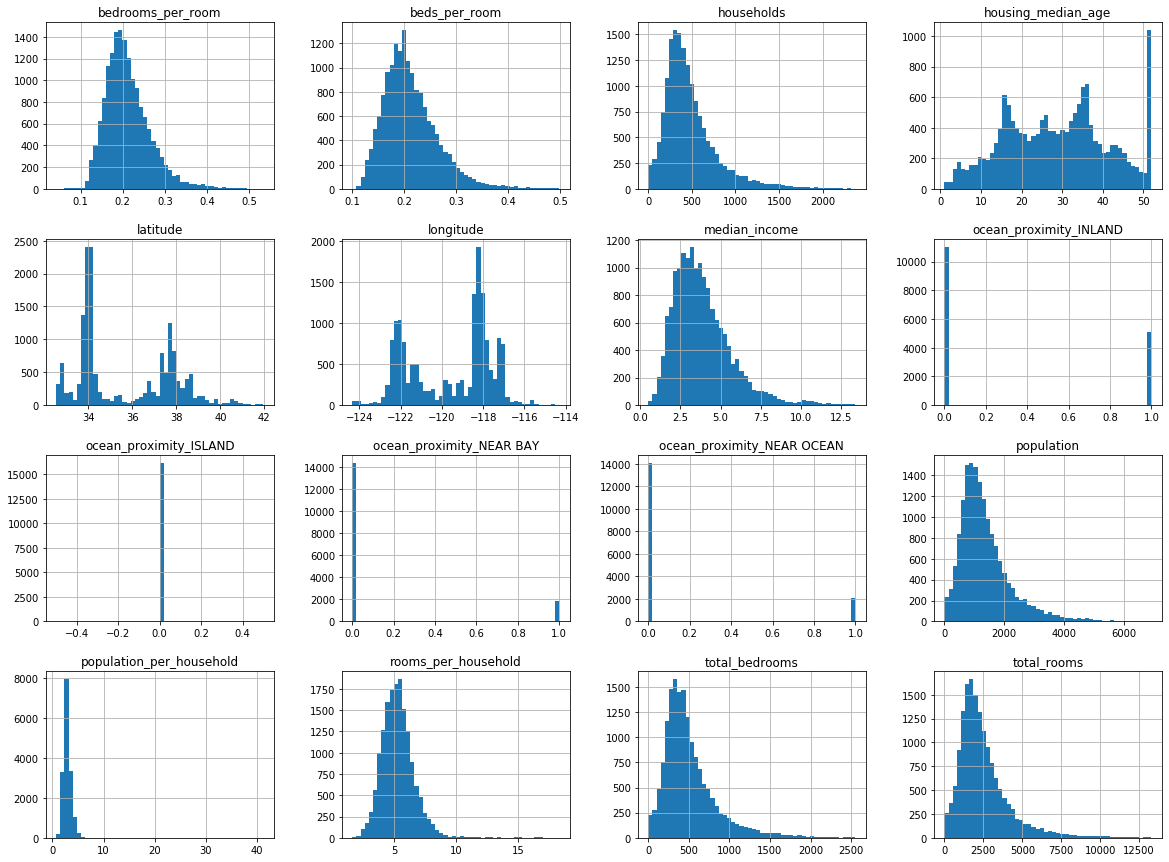

In [23]:
#Original distribustions
train.hist(bins = 50, figsize = (20,15));

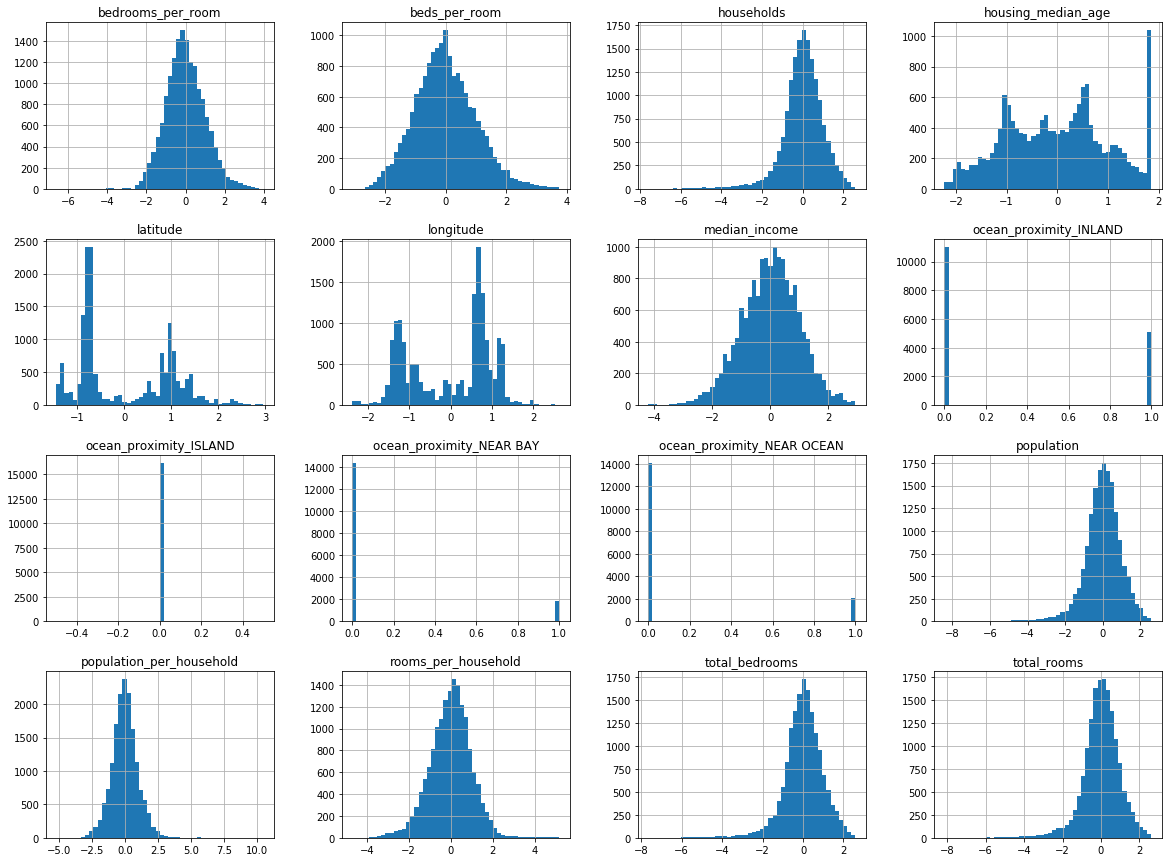

In [24]:
#Transformed distributions
std_train.hist(bins = 50, figsize = (20,15));

# Results of Preprocessing:

## We now have 2 groups of data coresponding to use in tree based and non-tree based models.

### labels_train and labels_test: 
These are the target features 
for all test and train datasets. They have not been 
preprocessed other that outlier removal.

### test and train: 
These have no missing features, are one-hot-encoded, 
include our engineered features, and have had outliers removed.





### labels_train_trans and labels_test_trans: 
These are the target features 
for the preprocessed test and train datasets. They have been transformed to remove skewness and had outliers removed.

### std_test and std_train:
These have no missing features, are one-hot-encoded,
include our engineered features, have been standardized/de-skewed, and have had outliers removed.

# MODEL SELECTION

In [56]:
#Kfold cross validation for Linear Regression, 
#Support Vector Regression, and Random Forrest.


#k fold cross validation for linear regressor with unscalled and standardized datasets
scores_lr, mean_err, std_LR = Kfold_RMSE(train,labels_train, False, 10,LinearRegression)

#k fold cross validation for linear regressor with fully preprocessed datasets
scores_lr_pre, mean_err_pre, std_LR_pre = Kfold_RMSE(std_train,labels_train_trans, True, 10,LinearRegression)

#k fold cross validation for SVR with fully preprocessed datasets
scores_SVR_pre, mean_err_pre, std_SVR_pre = Kfold_RMSE(std_train,labels_train_trans, True, 10,SVR)

#k fold cross validation for SVR with with unscalled and standardized datasets
scores_SVR, mean_err_pre, std_SVR = Kfold_RMSE(train,labels_train, False, 10,SVR)

#k fold cross validation for random forest with fully preprocessed datasets
scores_RF_pre, mean_err_pre, std_RF_pre = Kfold_RMSE(std_train,labels_train_trans, True, 10,RandomForestRegressor)

#k fold cross validation for random forest with fully preprocessed datasets
scores_RF, mean_err_pre, std_RF = Kfold_RMSE(train,labels_train, False, 10,RandomForestRegressor)

mean error is: 65737.20 with a standard deviation of 1697.77
mean error is: 65362.14 with a standard deviation of 2282.99
mean error is: 54411.53 with a standard deviation of 2146.40
mean error is: 118000.98 with a standard deviation of 2870.39
mean error is: 49659.12 with a standard deviation of 2205.90
mean error is: 49774.83 with a standard deviation of 1746.51


In [31]:
#linear regression model trained on the fully preprocessed datasets
lin_reg = LinearRegression()
lin_reg.fit(std_train,labels_train_trans)
predictions = lin_reg.predict(std_test)
error = mean_squared_error(np.exp(labels_test_trans), np.exp(predictions))
rmse_LR_pre = np.sqrt(error)
print(f"RMSE generaliziation error: {np.sqrt(error):.2f}")

RMSE generaliziation error: 65374.25


In [32]:
#linear regression model trained on the unscalled and standardized dataset
lin_reg = LinearRegression()
lin_reg.fit(train,labels_train)
predictions = lin_reg.predict(test)
error = mean_squared_error(labels_test, predictions)
rmse_LR = np.sqrt(error)
print(f"RMSE generaliziation error: {np.sqrt(error):.2f}")

RMSE generaliziation error: 69163.26


In [34]:
#Support Vector Regressor model trained on the fully preprocessed datasets
SVR_reg = SVR()
SVR_reg.fit(std_train,labels_train_trans)
predictions = SVR_reg.predict(std_test)

error = mean_squared_error(np.exp(labels_test_trans), np.exp(predictions))
rmse_SVR_pre = np.sqrt(error)
print(f"SVR RMSE generaliziation error: {np.sqrt(error):.2f}")

SVR RMSE generaliziation error: 53305.54


In [33]:
#Support Vector Regressor model trained on the the unscalled and non-standardized dataset
SVR_reg = SVR()
SVR_reg.fit(train,labels_train)
predictions = SVR_reg.predict(test)

error = mean_squared_error(labels_test, predictions)
rmse_SVR = np.sqrt(error)
print(f"SVR RMSE generaliziation error: {np.sqrt(error):.2f}")

SVR RMSE generaliziation error: 117319.18


In [35]:
#Random Forest model trained on the fully preprocessed datasets
RF_reg = RandomForestRegressor()
RF_reg.fit(std_train,labels_train_trans)
predictions = RF_reg.predict(std_test)

error = mean_squared_error(np.exp(labels_test_trans), np.exp(predictions))
rmse_RF_pre = np.sqrt(error)
print(f"Random Forest RMSE generaliziation error: {np.sqrt(error):.2f}")

Random Forest RMSE generaliziation error: 48970.81


In [36]:
#Random Forest model trained on the fully preprocessed datasets
RF_reg = RandomForestRegressor()
RF_reg.fit(train,labels_train)
predictions = RF_reg.predict(test)

error = mean_squared_error(labels_test, predictions)
rmse_RF = np.sqrt(error)
print(f"Random Forest RMSE generaliziation error: {np.sqrt(error):.2f}")

Random Forest RMSE generaliziation error: 48737.73
